# Hollow Rectangular RC Section

In [23]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

In [24]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
coverID, coreID, rebarID = 1, 2, 3
ops.uniaxialMaterial("Concrete01", coverID, -30, -0.002, -15, -0.005)
ops.uniaxialMaterial("Concrete01", coreID, -40, -0.006, -30, -0.015)
ops.uniaxialMaterial("Steel01", rebarID, 200, 2.0e5, 0.02)

In [25]:
# the points of the outer contour line, only the turning point of the line is needed, counterclockwise or clockwise.
outlines = [
    [0.5, 0],
    [7.5, 0],
    [8, 0.5],
    [8, 4.5],
    [7.5, 5],
    [0.5, 5],
    [0, 4.5],
    [0, 0.5],
]
# cover thick
cover_d = 0.08
# Offset to get the inner boundary of the cover layer
coverlines = opst.pre.section.offset(outlines, d=cover_d)

# Generate polygonal geometry object for cover layer
cover_geo = opst.pre.section.create_polygon_patch(outlines, holes=[coverlines])

# Creating core with voids
holelines1 = [[1, 1], [3.5, 1], [3.5, 4], [1, 4]]
holelines2 = [[4.5, 1], [7, 1], [7, 4], [4.5, 4]]
core_geo = opst.pre.section.create_polygon_patch(
    coverlines, holes=[holelines1, holelines2]
)

In [26]:
SEC_MESH = opst.pre.section.FiberSecMesh()
SEC_MESH.add_patch_group({"cover": cover_geo, "core": core_geo})
SEC_MESH.set_mesh_size({"cover": 0.5, "core": 0.5})
SEC_MESH.set_ops_mat_tag({"cover": coverID, "core": coreID})  # add opensees mat tag !!!
SEC_MESH.set_mesh_color({"cover": "#dbb40c", "core": "#88b378"})
SEC_MESH.mesh()

OPSTOOL :: The section My Section has been successfully meshed!

In [27]:
dia = 0.06
rebars_outer = opst.pre.section.offset(coverlines, d=dia / 2)
SEC_MESH.add_rebar_line(
    points=rebars_outer,
    dia=dia,
    n=200,
    ops_mat_tag=rebarID,  # add opensees mat tag
    group_name="rebar #30",
    color="#580f41",
)

dia = 0.045
rebars_inner = opst.pre.section.offset(holelines1, d=-dia / 2)
SEC_MESH.add_rebar_line(
    points=rebars_inner,
    dia=dia,
    gap=0.1,
    ops_mat_tag=rebarID,  # add opensees mat tag !!!
    group_name="rebar #25",
    color="#3d7afd",
)

rebars_inner = opst.pre.section.offset(holelines2, d=-dia / 2)
SEC_MESH.add_rebar_line(
    points=rebars_inner,
    dia=dia,
    gap=0.1,
    ops_mat_tag=rebarID,  # add opensees mat tag !!!
    group_name="rebar #25",
    color="#3d7afd",
)

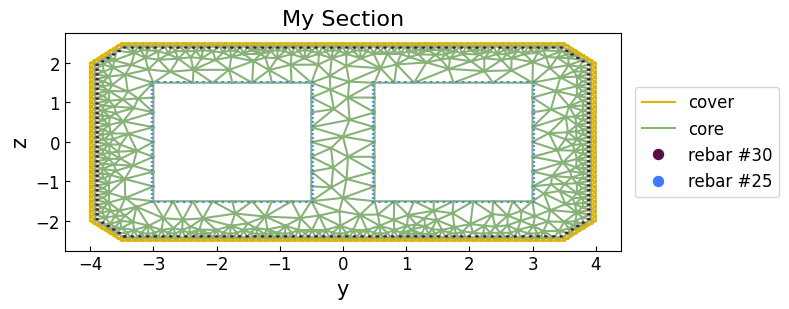

In [29]:
SEC_MESH.centring()
SEC_MESH.view(fill=False, show_legend=True)
plt.show()

In [30]:
props = SEC_MESH.get_frame_props(display_results=True)

                           Frame Section Properties                            
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol    ┃ Value                  ┃ Definition                             ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ A         │ 2.450E+01              │ Cross-sectional area                   │
│ centroid  │ (0.000E+00, 0.000E+00) │ Elastic centroid                       │
│ Iy        │ 6.935E+01              │ Moment of inertia y-axis               │
│ Iz        │ 1.522E+02              │ Moment of inertia z-axis               │
│ Iyz       │ -3.411E-13             │ Product of inertia                     │
│ Wyt       │ 2.774E+01              │ Section moduli of top fibres y-axis    │
│ Wyb       │ 2.774E+01              │ Section moduli of bottom fibres y-axis │
│ Wzt       │ 3.806E+01              │ Section moduli of top fibres z-axis    │
│ Wzb       │ 3.806E+01              │ Section moduli of bottom fibres z-axis │
│ J         │ 1.584E+02              │ Torsion constant                       │
│ phi       │ -9.000E+01             │ Principal axis angle                   │
│ rho_rebar │ 3.738E-02              │ Ratio of reinforcement                 │
└───────────┴────────────────────────┴────────────────────────────────────────┘

In [31]:
G = 10000  # shear modulus of the concrete
J = props["J"]  # get the torsional constant
GJ = G * J
GJ

1583783.666324338

In [32]:
SEC_MESH.centring()

sec_tag = 1
SEC_MESH.to_opspy_cmds(secTag=sec_tag, GJ=GJ)  # to the opensees commands

In [33]:
ops.node(1, 0, 0, 0)
ops.node(2, 0, 0, 0)

sec_tag = 1
ops.element("zeroLengthSection", sec_tag, 1, 2, sec_tag)